In [1]:
# import the necessary packages
# python image_stitching_simple.py --images images/scottsdale/test --output output3.png --crop 1
# python image_stitching_simple.py --images images/scottsdale --output output4.png --crop 1
from imutils import paths
import numpy as np
# import argparse
import imutils
import cv2
import matplotlib.pyplot as plt


from pathlib import Path

# # construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--images", type=str, required=True,
#                 help="path to input directory of images to stitch")
# ap.add_argument("-o", "--output", type=str, required=True,
#                 help="path to the output image")
# ap.add_argument("-c", "--crop", type=int, default=0,
#                 help="whether to crop out largest rectangular region")
# args = vars(ap.parse_args())

args = {
    "images": "/home/ajc/Documents/terrain-classification/image-data/tmp"
}

In [2]:
# grab the paths to the input images and initialize our images list
print("[INFO] loading images...")
imagePaths = sorted(list(paths.list_images(args["images"])))
images = []

# loop over the image paths, load each one, and add them to our
# images to stitch list
for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    images.append(image)

[INFO] loading images...


IndexError: list index out of range

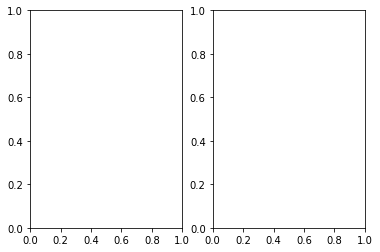

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB));
ax2.imshow(cv2.cvtColor(images[1], cv2.COLOR_BGR2RGB));

In [4]:
import numpy as np
import cv2

# import the necessary packages
import numpy as np
import imutils
import cv2

class ViewSynthisizer:
    def __init__(self):
        # determine if we are using OpenCV v3.X and initialize the
        # cached homography matrix
        self.isv3 = imutils.is_cv3(or_better=True)
        self.cachedH = None

    def stitch(self, images, ratio=0.75, reprojThresh=4.0):
        # unpack the images
        (imageB, imageA) = images

        # if the cached homography matrix is None, then we need to
        # apply keypoint matching to construct it
        if self.cachedH is None:
            # detect keypoints and extract
            (kpsA, featuresA) = self.detectAndDescribe(imageA)
            (kpsB, featuresB) = self.detectAndDescribe(imageB)

            # match features between the two images
            M = self.matchKeypoints(kpsA, kpsB,
                featuresA, featuresB, ratio, reprojThresh)

            # if the match is None, then there aren't enough matched
            # keypoints to create a panorama
            if M is None:
                return None

            # cache the homography matrix
            self.cachedH = M[1]

        # apply a perspective transform to stitch the images together
        # using the cached homography matrix
        result = cv2.warpPerspective(imageA, self.cachedH,
            (imageA.shape[1] + imageB.shape[1], imageA.shape[0]))
        result[0:imageB.shape[0], 0:imageB.shape[1]] = imageB
        
        self.cachedH = None

        # return the stitched image
        return result

    def detectAndDescribe(self, image):
        # convert the image to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # detect and extract features from the image
        descriptor = cv2.ORB_create()
        (kps, features) = descriptor.detectAndCompute(image, None)

        # convert the keypoints from KeyPoint objects to NumPy
        # arrays
        kps = np.float32([kp.pt for kp in kps])

        # return a tuple of keypoints and features
        return (kps, features)

    def matchKeypoints(self, kpsA, kpsB, featuresA, featuresB,
        ratio, reprojThresh):
        # compute the raw matches and initialize the list of actual
        # matches
        matcher = cv2.DescriptorMatcher_create("BruteForce")
        rawMatches = matcher.knnMatch(featuresA, featuresB, 2)
        matches = []

        # loop over the raw matches
        for m in rawMatches:
            # ensure the distance is within a certain ratio of each
            # other (i.e. Lowe's ratio test)
            if len(m) == 2 and m[0].distance < m[1].distance * ratio:
                matches.append((m[0].trainIdx, m[0].queryIdx))

        # computing a homography requires at least 4 matches
        if len(matches) > 4:
            # construct the two sets of points
            ptsA = np.float32([kpsA[i] for (_, i) in matches])
            ptsB = np.float32([kpsB[i] for (i, _) in matches])

            # compute the homography between the two sets of points
            (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
                reprojThresh)

            # return the matches along with the homograpy matrix
            # and status of each matched point
            return (matches, H, status)

        # otherwise, no homograpy could be computed
        return None

In [5]:
img_dir = Path('/home/ajc/Documents/terrain-classification/image-data/01-single-rgb/')

out_dir = Path('/home/ajc/Documents/terrain-classification/image-data/03-panoramas/')

img_classes = ['high', 'medium', 'low']

synth = ViewSynthisizer()

num_dead = 0

for clss in img_classes:
    
    img_fnames_left = sorted((img_dir / clss).glob('*eft-[0-9]*.jpg'))
    img_fnames_right = sorted((img_dir / clss).glob('*ight-[0-9]*.jpg'))
    
    print(clss, len(img_fnames_right)*2)
    
    out_dir_class = out_dir / clss
    out_dir_class.mkdir(parents=True, exist_ok=True)

    for fname_left, fname_right in zip(img_fnames_left, img_fnames_right):

        img_left = plt.imread(fname_left)# cv2.imread(str(fname_left))
        img_right = plt.imread(fname_right)#cv2.imread(str(fname_right))

        pan_frame = synth.stitch([img_left, img_right])
        
        out_fname = fname_left.name
        out_fpath = out_dir_class / out_fname
        
        if pan_frame is None:
            print(fname_left.name, fname_right.name)
            num_dead += 1
        
        else:
            plt.imsave(out_fpath, pan_frame)
        
#         break
#     break

print(num_dead)

high 4688
High-Dirt-Full-Left-0.jpg High-Dirt-Full-Right-0.jpg
High-Dirt-Full-Left-1.jpg High-Dirt-Full-Right-1.jpg
High-Dirt-Full-Left-10.jpg High-Dirt-Full-Right-10.jpg
High-Dirt-Full-Left-100.jpg High-Dirt-Full-Right-100.jpg
High-Dirt-Full-Left-101.jpg High-Dirt-Full-Right-101.jpg
High-Dirt-Full-Left-102.jpg High-Dirt-Full-Right-102.jpg
High-Dirt-Full-Left-103.jpg High-Dirt-Full-Right-103.jpg
High-Dirt-Full-Left-104.jpg High-Dirt-Full-Right-104.jpg
High-Dirt-Full-Left-105.jpg High-Dirt-Full-Right-105.jpg
High-Dirt-Full-Left-106.jpg High-Dirt-Full-Right-106.jpg
High-Dirt-Full-Left-107.jpg High-Dirt-Full-Right-107.jpg
High-Dirt-Full-Left-108.jpg High-Dirt-Full-Right-108.jpg
High-Dirt-Full-Left-109.jpg High-Dirt-Full-Right-109.jpg
High-Dirt-Full-Left-11.jpg High-Dirt-Full-Right-11.jpg
High-Dirt-Full-Left-110.jpg High-Dirt-Full-Right-110.jpg
High-Dirt-Full-Left-111.jpg High-Dirt-Full-Right-111.jpg
High-Dirt-Full-Left-112.jpg High-Dirt-Full-Right-112.jpg
High-Dirt-Full-Left-113.jpg High-

error: OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/imgwarp.cpp:2926: error: (-215:Assertion failed) (M0.type() == 5 || M0.type() == 6) && M0.rows == 3 && M0.cols == 3 in function 'warpPerspective'
